In [650]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import plotly.colors
import plotly.graph_objects as go

In [651]:
# Reading attendance data
df_frequentation = pd.read_csv('data/frequentation-gares.csv', sep=';')
# Reading train station data
df_gares = pd.read_csv('data/referentiel-gares-voyageurs.csv', sep=';')
df = df_gares.merge(
    right=df_frequentation, 
    left_on='Code UIC', 
    right_on='Code UIC complet', 
    how='inner')

# Reading found items data
df_objects = pd.read_csv('data/objets-trouves-restitution.csv', sep=';')
df = df.merge(df_objects, left_on='Code UIC', right_on='Code UIC', how='right')

In [652]:
# Filtering by date
df['Date'] = pd.to_datetime(df.Date, utc=True).dt.tz_convert('Europe/Paris')
df = df[df.Date.dt.year >= 2015]

In [653]:
# Grouping by train station
df_grouped = (df
    .groupby(by='Gare')
    .count()
    .Date
    .rename('Count')
    .sort_values(ascending=False)
)

df_cumsum = df_grouped.cumsum()
pareto = (df_cumsum < df_cumsum.max() * 0.8).sum()

# Only keep first 30
df_grouped = df_grouped.iloc[:30]

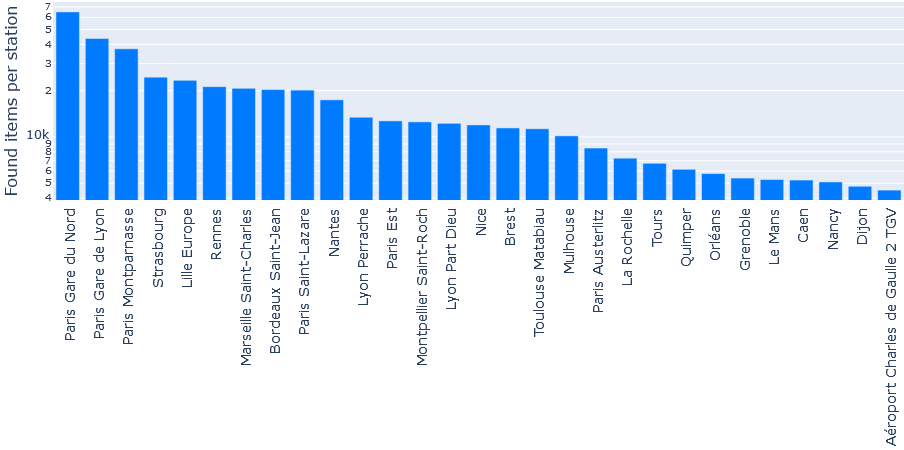

In [654]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=np.arange(1, len(df_grouped)), 
        y=df_grouped, 
        text=df_grouped.index,
        meta = df_grouped,
        hoverinfo="text+y",
        name="Found items",
        marker_color="#007bff"
))

fig.update_layout(
    margin={'l':20, 'r': 0, 't': 0, 'b': 250},
    xaxis=dict(tickmode='array',
               tickvals=np.arange(1, len(df_grouped)),
               ticktext=df_grouped.index.tolist(),
               tickangle=-90,
               tickfont={'size': 14}),
    yaxis=dict(title="Found items per station",
               type="log",
               titlefont=dict(size=16))
)

fig.show()

In [655]:
py.plot(fig, filename = 'sncf-found-items', auto_open=True)

'https://plotly.com/~hugolmn/14/'

In [634]:
# grouping by year and month
df_months = df.groupby(by=[df.Date.dt.year, df.Date.dt.month]).Date.count()
df_months.index = pd.to_datetime(dict(year=[i[0] for i in df_months.index], month=[i[1] for i in df_months.index], day=1))

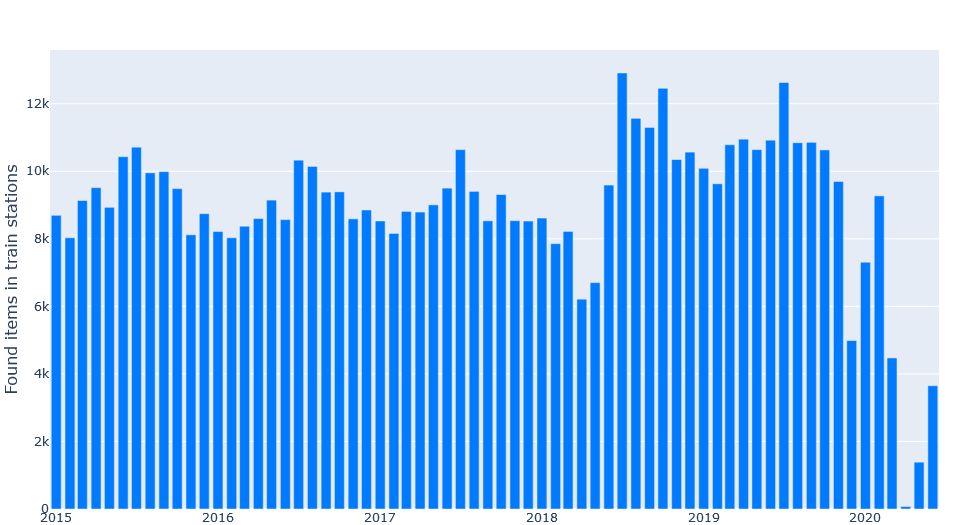

In [656]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df_months.index,
        y=df_months, 
        text=df_months,
        meta = df_months,
        hoverinfo="x+y",
        marker_color="#007bff",  
))

fig.update_layout(
    width=800,
    height=525,
    yaxis=dict(title="Found items in train stations", titlefont=dict(size=16)),
    margin={'l': 30, 'r': 30, 't': 50, 'b': 0},
)

In [657]:
py.plot(fig, filename='sncf-monthly-found-items', auto_open=True)

'https://plotly.com/~hugolmn/21/'

In [641]:
df_stations = df.loc[(df.Date.dt.year >= 2015) & (df.Date.dt.year <= 2018)].copy()
df_stations['Passengers'] =(df_stations['Total Voyageurs 2018'] 
                    + df_stations['Total Voyageurs 2017'] 
                    + df_stations['Total Voyageurs 2016'] 
                    + df_stations['Total Voyageurs 2015'])
df_stations = (df_stations.groupby(by="Intitulé gare")
            .agg({'Longitude WGS84': 'first',
                  'Latitude WGS84': 'first',
                  'Nature d\'objets': len,
                  'Passengers': 'first',}
                  )
            .rename(columns={'Nature d\'objets': 'Count',}))

In [642]:
df_stations = df_stations[df_stations.Count >= 10]
df_stations['category'] = pd.cut(df_stations['Count'], bins=[1e1, 2.5e2, 1e3, 5e3, 1e4, np.inf])

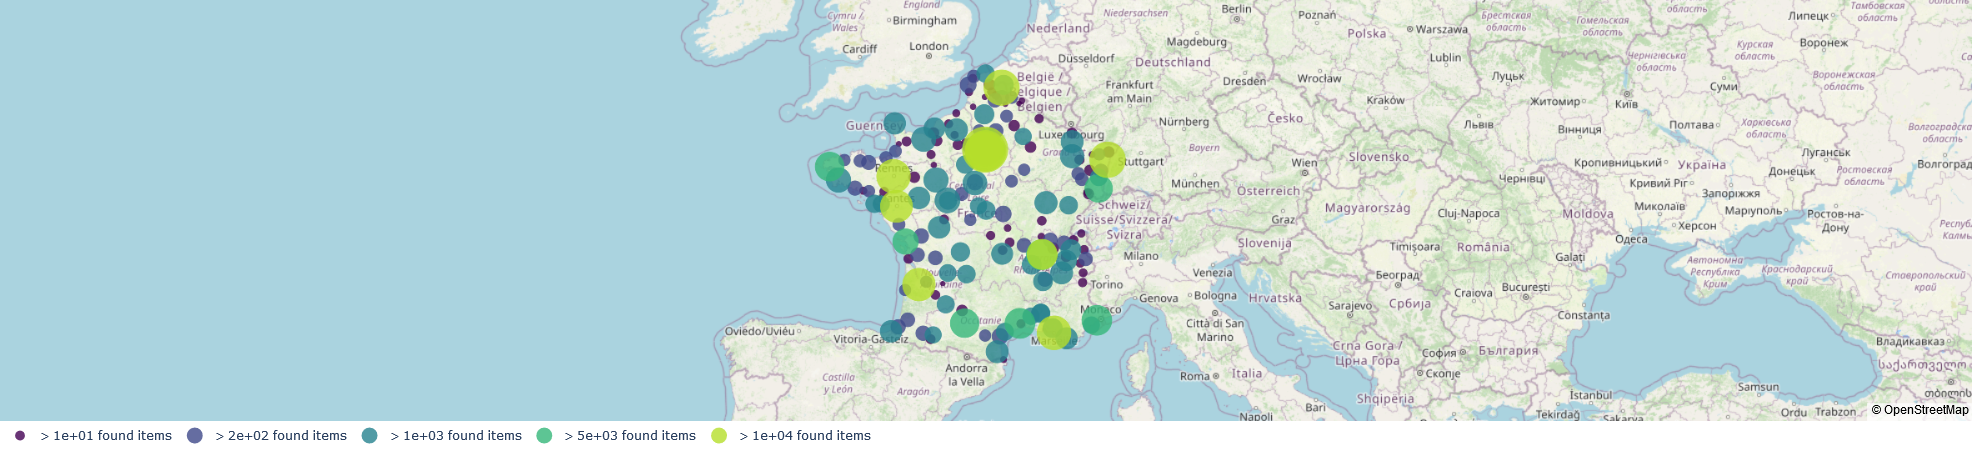

In [645]:
# Map
fig = go.Figure()
colors = plotly.colors.sequential.Viridis

for i, cat in enumerate(df_stations.category.cat.categories):
    df_sub = df_stations[df_stations.category == cat]
    fig.add_trace(go.Scattermapbox(
            lat=df_sub['Latitude WGS84'], 
            lon=df_sub['Longitude WGS84'],
            text=df_sub.index,
            marker=dict(
                color=colors[2*i],
                size=np.sqrt(df_sub['Count']),
                sizemin=1,
                sizeref=.2,
                sizemode='area',
                opacity=.8,
            ),
            meta=df_sub['Count'],
            hovertemplate="%{text}" + "<br>" + "Found items: %{meta}",
            name=f'> {cat.left:1.0e} found items',          
    ))
    
fig.update_layout(
    mapbox_style="open-street-map",
    #title='Passengers per french train station in 2018',
    margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
    mapbox=dict(
        center={'lon': 2.39, 'lat': 47.09},
        zoom=4
    ),
)

fig.update_layout(legend={'orientation': 'h', 'y': 0})

fig.show(config={'scrollZoom': True})

In [646]:
df_stations['count_per_100kpax'] = df_stations.Count / df_stations.Passengers * 1e5
df_stations = df_stations.sort_values(by='count_per_100kpax', ascending=False)

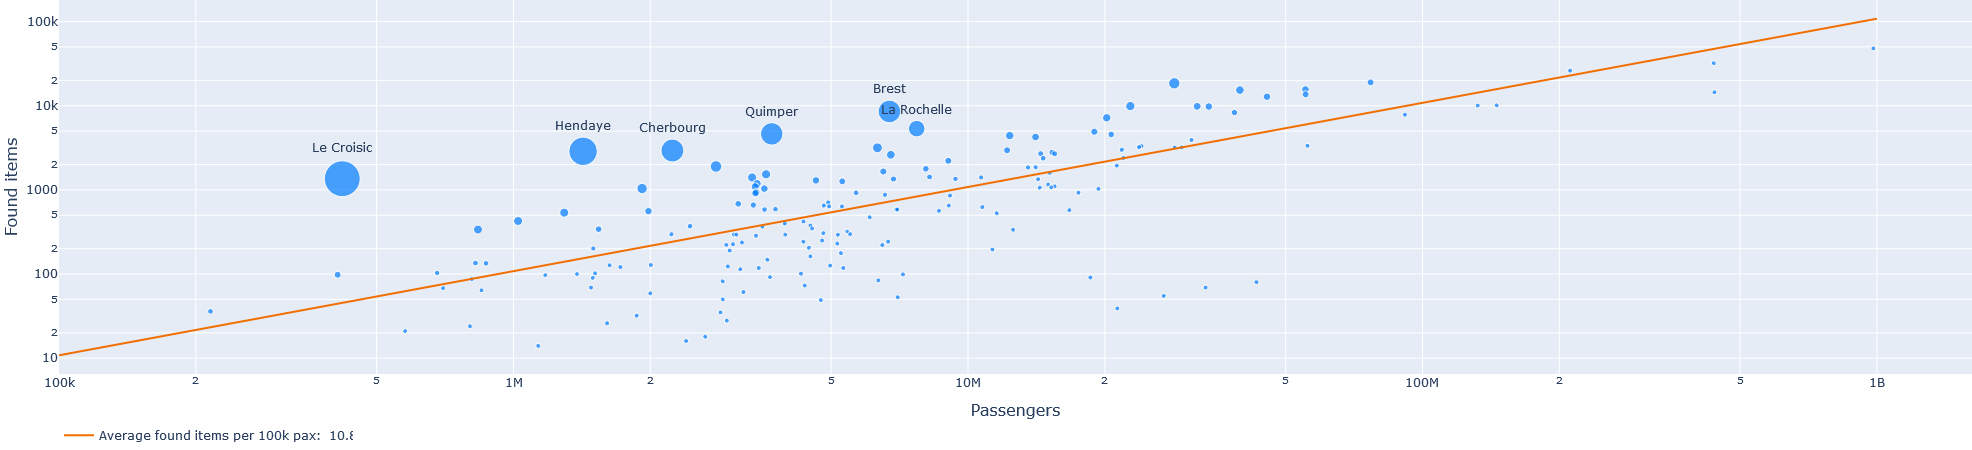

In [647]:
fig = go.Figure()

df_sub=df_stations.iloc[6:]
fig.add_trace(go.Scatter(
    x=df_sub.Passengers,
    y=df_sub.Count, 
    mode='markers',
    marker=dict(
        size=df_sub.count_per_100kpax,
        sizemode='area',
        sizemin=2.5,
        sizeref=1,
        color="#007bff"
    ),
    text=df_sub.index,
    hovertemplate="%{text}<br>" 
                    + "Found items: %{y}<br>" 
                    + "Passengers: %{x}<br>"
                    + "Found items per 100k passengers: %{marker.size:.1f}",
    name="",
    showlegend=False,
))

df_sub=df_stations.iloc[:6]
fig.add_trace(go.Scatter(
    x=df_sub.Passengers,
    y=df_sub.Count, 
    mode='markers+text',
    marker=dict(
        size=df_sub.count_per_100kpax,
        sizemode='area',
        sizemin=2.5,
        sizeref=.5,
        color="#007bff"
    ),
    text=df_sub.index,
    textposition='top center',
    hovertemplate="%{text}<br>" 
                    + "Found items: %{y}<br>" 
                    + "Passengers: %{x}<br>"
                    + "Found items per 100k passengers: %{marker.size:.1f}",
    name="",
    showlegend=False,
))

fig.add_trace(go.Scatter(
    x=np.logspace(5, 9, 10),
    y=np.logspace(5, 9, 10) * df_stations.Count.sum() / df_stations.Passengers.sum(),
    mode='lines',
    name=f'Average found items per 100k pax: {df_stations.Count.sum() / df_stations.Passengers.sum() * 1e5: .1f}',
    hoverinfo='skip',
    marker=dict(color="#F16E00")
))

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
    xaxis=dict(type='log', title_text="Passengers", titlefont=dict(size=16)),
    yaxis=dict(type='log', title_text="Found items", titlefont=dict(size=16)),
    legend=dict(orientation='h', y=-.125)
)

fig.show(config={'scrollZoom': True})